In [22]:
# Libraries

# For getting rid of FutureWarning later
# Will try and fix that code if I have time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.ticker

# Generic
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import calendar

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [23]:
# Data cleaning
def data_cleaner(discharge_path, height_path):
    # Read to df
    dischargeDf = pd.read_csv(discharge_path)
    heightDf = pd.read_csv(height_path)
    # Clean columns (discharge)
    # Running averages (Q7, Q30) might be interesting to look at in the models
    dischargeDf = dischargeDf[['Date','Month','Day','Q','waterYear','Q7','Q30']]
    # Rename columns to make more sense in context and prep for merge
    dischargeDf = dischargeDf.rename(columns={'Day':'DayofYear', 'Q':'Discharge'})
    # Clean columns (height)
    heightDf = heightDf[['Date','X_00065_00003']]
    # Rename
    heightDf = heightDf.rename(columns={'X_00065_00003':'gageHeight'})
    # Merge
    cleanDf = dischargeDf.merge(heightDf, on='Date')
    return cleanDf

# Cleaned DFs
tarDf = data_cleaner('data/tar_discharge.csv','data/tar_height.csv')
neuseDf = data_cleaner('data/neuse_discharge.csv','data/neuse_height.csv')
capeDf = data_cleaner('data/capefear_discharge.csv','data/capefear_height.csv')


In [24]:
# Creating "season" groups
# Added "day of week" creator as well

def season_maker(dataframe):
    dataframe['Season'] = ''
    for index, row in dataframe.iterrows():
        month = row['Month']
        # Assigning seasons based on month
        if month in [12,1,2]:
            dataframe.loc[index, 'Season'] = 'Winter'
        elif month in [3,4,5]:
            dataframe.loc[index, 'Season'] = 'Spring'
        elif month in [6,7,8]:
            dataframe.loc[index, 'Season'] = 'Summer'
        elif month in [9,10,11]:
            dataframe.loc[index, 'Season'] = 'Fall'
    dataframe['Date']=pd.to_datetime(dataframe['Date'], format='%Y-%m-%d')
    dataframe['DayofWeek']=dataframe['Date'].dt.dayofweek
    return dataframe




# Adding groups to DFs
tarDf = season_maker(tarDf)
neuseDf = season_maker(neuseDf)
capeDf = season_maker(capeDf)

In [25]:
""" ### TO DO:
### fix axes
### remove day of week -> maximums or 90th percentile values by season

def data_viz(dataframe, rivername):
    fig, axarr = plt.subplots(2, 2, figsize=(14,6), sharey=False)     
    # Plot mean discharge per water year
    plt.sca(axarr[0,0])
    plt.plot(dataframe[['waterYear','Discharge']].groupby(['waterYear']).mean())
    plt.title(f'{rivername} Mean Discharge by Water Year')
    plt.xticks(dataframe['waterYear'].values, minor=True)
    plt.xlabel('Water Year')
    plt.ylabel('Discharge (mean)')

    # Avg discharge by month

    plt.sca(axarr[0,1])

    monthlydischarge = dataframe[['Month','Discharge']].groupby(['Month']).mean()
    monthlystd = dataframe[['Month','Discharge']].groupby(['Month']).std()

    # Month number to abbreviated name
    months = []
    for i in range(1,13):
        months.append(calendar.month_abbr[i])

    plt.bar(months, monthlydischarge['Discharge'], yerr=monthlystd['Discharge'], align='center', ecolor='darkblue', capsize=5)
    plt.xticks(range(0,13))
    plt.ylabel('Average Discharge')
    plt.xlabel('Month')
    plt.ylim(0,None)
    plt.title(f'{rivername} Mean Discharge by Month')

    # maximums or 90th percentile values by season
    plt.sca(axarr[1,0])

    # Separate discharge by season
    # Get percentiles for each season
    percentile95 = dataframe[['Season','Discharge']].groupby(['Season'])['Discharge'].quantile(0.95)
    seasons = ['Fall','Winter','Spring','Summer']
    # Put on bar graph
    ### this is the hard part
    plt.bar(seasons, percentile95, align='center', ecolor='darkblue', capsize=5, label="95th percentile")

    plt.ylabel('Discharge')
    plt.xlabel('Season')
    plt.ylim(0,None)
    plt.title(f'{rivername} 95th Percentile Discharge by Season')
    
    # Violin plot of all discharge
    plt.sca(axarr[1,1])
    # sns.violinplot(x=dataframe['Discharge'], linecolor='black')
    # plt.title(f'Violin Plot of {rivername} Discharge')

    sns.violinplot(data=dataframe[['Season','Discharge']], x='Season', y='Discharge', linecolor='black')
    plt.title(f'Violin Plot of {rivername} Discharge by Season')


    # Prevent clipping
    plt.tight_layout()
    plt.show()

data_viz(tarDf,'Tar River')
data_viz(neuseDf,'Neuse River')
data_viz(capeDf,'Cape Fear River') """

' ### TO DO:\n### fix axes\n### remove day of week -> maximums or 90th percentile values by season\n\ndef data_viz(dataframe, rivername):\n    fig, axarr = plt.subplots(2, 2, figsize=(14,6), sharey=False)     \n    # Plot mean discharge per water year\n    plt.sca(axarr[0,0])\n    plt.plot(dataframe[[\'waterYear\',\'Discharge\']].groupby([\'waterYear\']).mean())\n    plt.title(f\'{rivername} Mean Discharge by Water Year\')\n    plt.xticks(dataframe[\'waterYear\'].values, minor=True)\n    plt.xlabel(\'Water Year\')\n    plt.ylabel(\'Discharge (mean)\')\n\n    # Avg discharge by month\n\n    plt.sca(axarr[0,1])\n\n    monthlydischarge = dataframe[[\'Month\',\'Discharge\']].groupby([\'Month\']).mean()\n    monthlystd = dataframe[[\'Month\',\'Discharge\']].groupby([\'Month\']).std()\n\n    # Month number to abbreviated name\n    months = []\n    for i in range(1,13):\n        months.append(calendar.month_abbr[i])\n\n    plt.bar(months, monthlydischarge[\'Discharge\'], yerr=monthlystd[\'Dis

In [26]:
# Filling in missing data: points surrounding the data
# Might use a ML-based approach for filling in information
# Particularly for Neuse, given there are 9 year gaps


# Fill in missing dates
#date_range = pd.date_range(start=neuseDf['Date'].min(), end=neuseDf['Date'].max())
#date_range_df = pd.DataFrame(date_range, columns=['Date'])
#df_filled = pd.merge(date_range_df, neuseDf, on='Date', how='left')

# Adding missing seasons
#df_seasons=season_maker(df_filled)

# Remove dates that are before the gap ends
# Going to start in 2003 for safety




In [27]:
# Filling in missing data with proximity points
# Neuse's closest gages are: 
# USGS 02087275 CRABTREE CREEK AT HWY 70 AT RALEIGH, NC
# USGS 0208732885 MARSH CREEK NEAR NEW HOPE, NC
pd.options.mode.chained_assignment = None

prox1Df = data_cleaner('data/neuse_proximity_gages/prox_discharge1.csv', 'data/neuse_proximity_gages/prox_height1.csv')
prox2Df = data_cleaner('data/neuse_proximity_gages/prox_discharge2.csv', 'data/neuse_proximity_gages/prox_height2.csv')

# Only pulling points from missing years (1992-2002 ish)
prox1 = prox1Df.loc[prox1Df['waterYear'].isin(range(1991,2005))]
prox2 = prox2Df.loc[prox2Df['waterYear'].isin(range(1991,2005))]

prox1real = season_maker(prox1)
prox2real = season_maker(prox2)

# These only cover about half the missing points
# Try and fill in the missing data with a ML model?
# Probably use RandomForest since it works well consistently
# Need to one hot encode 'Season' (since models die if I use non-numbers)

neusecombo = pd.concat([neuseDf, prox1real, prox2real], ignore_index=True)
neusecombo1 = neusecombo[neusecombo['waterYear'].isin(range(1997,neusecombo['waterYear'].max()))]

neuseDf = neusecombo1.copy()


In [28]:
# Time to impute data
# For Tar and Cape Fear, there is small enough gaps to where I can just use linear interpolation. Yay!

def skipped_days(dataframe):
    # Convert 'date' column to datetime
    dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    
    # Fill in missing dates
    date_range = pd.date_range(start=dataframe['Date'].min(), end=dataframe['Date'].max())
    date_range_df = pd.DataFrame(date_range, columns=['Date'])
    df_filled = pd.merge(date_range_df, dataframe, on='Date', how='left')
    
    # Adding missing seasons
    result_df=season_maker(df_filled)
    result_df['DayofYear']=result_df['Date'].dt.dayofyear
    result_df['Month']=result_df['Date'].dt.month

    

    # Indicates whether or not a row has been imputed
    result_df['imputed'] = 0
    
    # Columns to interpolate
    columns_to_interpolate = ['Discharge','Q7','Q30','gageHeight']
    for column in columns_to_interpolate:
        mask = result_df[column].isna()
        # Adds a value of 1 for all imputed rows
        result_df.loc[mask, 'imputed'] = 1
        # Interpolate with linear interpolation
        result_df[column] = result_df[column].interpolate(method='linear')
    
    # Filling waterYear
    #if result_df.isnull(row['waterYear']):
    #return result_df.isna().sum()
    return result_df
skipped_days(tarDf)
skipped_days(capeDf)
skipped_days(neuseDf)

,Date,Month,DayofYear,Discharge,waterYear,Q7,Q30,gageHeight,Season,DayofWeek,imputed
0,1996-10-01,10,275,1.250276,1997.0,1.205779,23.384611,2.54,Fall,1,0
1,1996-10-02,10,276,1.448494,1997.0,1.290729,23.414816,2.64,Fall,2,0
2,1996-10-03,10,277,1.844930,1997.0,1.424223,23.461067,2.51,Fall,3,0
3,1996-10-04,10,278,1.448494,1997.0,1.505128,23.423311,2.46,Fall,4,0
4,1996-10-05,10,279,1.108692,1997.0,1.549626,23.388387,2.44,Fall,5,0
...,...,...,...,...,...,...,...,...,...,...,...
13469,2023-09-26,9,269,3.105107,2023.0,3.125333,3.866830,1.25,Fall,1,0
13470,2023-09-27,9,270,3.105107,2023.0,3.113198,3.806421,1.25,Fall,2,0
13471,2023-09-28,9,271,3.105107,2023.0,3.109152,3.746956,1.25,Fall,3,0
13472,2023-09-29,9,272,3.105107,2023.0,3.109152,3.703536,1.25,Fall,4,0


In [29]:
# Flood event & hydrologic event

def event_def(dataframe):
    # Flood: gage height >= 95th percentile
    dataframe['Flood'] = np.where(dataframe['gageHeight']>=dataframe['gageHeight'].quantile(0.95),1,0)
    # Hydrologic event: discharge >= 90th percentile, gage height < 95th percentile
    dataframe['HydroEvent'] = np.where((dataframe['Discharge']>=dataframe['Discharge'].quantile(0.9)) & (dataframe['gageHeight']<dataframe['gageHeight'].quantile(0.95)),1,0)
    return dataframe

tarEvent = event_def(tarDf)
neuseEvent = event_def(neuseDf)
capeEvent = event_def(capeDf)

print(tarEvent)

           Date  Month  DayofYear  Discharge  waterYear         Q7        Q30  \
0    1997-10-01     10        275   0.052471       1998   0.086451   0.090887   
1    1997-10-02     10        276   0.046808       1998   0.073911   0.089094   
2    1997-10-03     10        277   0.043976       1998   0.063393   0.087584   
3    1997-10-04     10        278   0.041144       1998   0.056921   0.086357   
4    1997-10-05     10        279   0.041144       1998   0.051257   0.085507   
...         ...    ...        ...        ...        ...        ...        ...   
9546 2024-01-27      1         27   5.073048       2024   3.481641  15.786349   
9547 2024-01-28      1         28  26.282366       2024   6.713807  16.273399   
9548 2024-01-29      1         29  17.900579       2024   8.833525  16.646237   
9549 2024-01-30      1         30   8.725921       2024   9.680199  16.777439   
9550 2024-01-31      1         31   6.630474       2024  10.240872  16.869940   

      gageHeight  Season  D

In [30]:
# Let's try and fit a linear model so I can see if variables are significant predictors
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def linear_reg_model(dataframe):
    # Turning Season into dummy variable
    dataframe = pd.get_dummies(dataframe, columns=['Season'], drop_first=True, dtype=int)
    

    
    # waterYear, 7 day rolling avg., 30 day rolling avg., gageHeight, season
    # not using month bc of Season variable
    X = dataframe[['waterYear', 'Flood', 'HydroEvent', 'Q7', 'Q30', 'gageHeight', 'Season_Spring', 'Season_Summer','Season_Winter']]
    y = dataframe['Discharge']
    X = sm.add_constant(X)

    # Calculating VIF to justify high condition number
    vif_df = pd.DataFrame()
    vif_df['variable'] = X.columns 
    vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif_df)

    model = sm.OLS(y, X).fit()
    return model.summary()


#linear_reg_model(tarDf)
linear_reg_model(neuseDf)
#linear_reg_model(capeDf)

        variable            VIF
0          const  133653.137750
1      waterYear       1.938635
2          Flood       1.587914
3     HydroEvent       2.053454
4             Q7       3.438879
5            Q30       2.566773
6     gageHeight       2.546284
7  Season_Spring       1.629081
8  Season_Summer       1.507238
9  Season_Winter       1.561372


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Discharge   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     6466.
Date:                Mon, 29 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:11:56   Log-Likelihood:                -49732.
No. Observations:               13394   AIC:                         9.948e+04
Df Residuals:                   13384   BIC:                         9.956e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -612.1821     31.333    -19.538      0.000    -673.598    -550.766
waterYear         0.3034      0.016     19.513      0.000       0.273       0.334
Flood             1.6245      0.493      3.298      0.001       0.659       2.590
HydroEvent       38.9168      0.419     92.800      0.000      38.095      39.739
Q7                0.5156      0.008     65.266      0.000       0.500       0.531
Q30              -0.0525      0.009     -6.151      0.000      -0.069      -0.036
gageHeight        1.8374      0.082     22.286      0.000       1.676       1.999
Season_Spring     1.2336      0.252      4.903      0.000       0.740       1.727
Season_Summer    -0.2127      0.243     -0.876      0.381      -0.689       0.263
Season_Winter     0.3987      0.248      1.605      0.109      -0.088       0.886
==============================================================================
Omnibus:                    14558.436   Durbin-Watson:                   0.864
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4235847.162
Skew:                           5.043   Prob(JB):                         0.00
Kurtosis:                      89.535   Cond. No.                     7.34e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.34e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
# Rolling 30 year MAXIMUM
from scipy.stats import genextreme

def returnvals(dataframe, window_width):
    # Steps:
    # Grab first 30 year window
    # Fit all observations to Gumbel distribution
    # Pull value to be in top 10% of observations
    years = dataframe['waterYear'].unique()
    designflood = pd.DataFrame()
    endyear=[]
    returnperiod=[]
    discharge=[]
    for i in range(len(years) - window_width + 1):
        # Returns the window of years
        window = years[i : (i + window_width)]
        datapoints = dataframe[dataframe['waterYear'].isin(window)]['Discharge']

        # https://stackoverflow.com/questions/71202562/calculating-return-value-using-generalised-extreme-value-distribution-gev

        shape, loc, scale = genextreme.fit(datapoints)
        return_periods = np.array([25, 50, 100])
        return_levels = genextreme.isf(1/return_periods, shape, loc, scale)

        #print("Return levels:")
        #print()
        #print("Period    Level")
        #print("(years)   (temp)")

        for period, level in zip(return_periods, return_levels):
            endyear.append(window[-1])
            returnperiod.append(period)
            discharge.append(level)
            #print(f'{period:4.0f}  {level:9.2f}')
        
        # Save values relative to the end of the final year
    designflood['endyear']=endyear
    designflood['returnperiod']=returnperiod
    designflood['discharge']=discharge
    return designflood


        


# tar - no event
tar_3 = returnvals(tarDf, 3)
tar_5 = returnvals(tarDf, 5)
tar_10 = returnvals(tarDf, 10)
# cape - no event
cape_3 = returnvals(capeDf, 3)
cape_5 = returnvals(capeDf, 5)
cape_10 = returnvals(capeDf, 10)
# neuse - no event
neuse_3 = returnvals(neuseDf, 3)
neuse_5 = returnvals(neuseDf, 5)
neuse_10 = returnvals(neuseDf, 10)

In [32]:
# Prepping event/flood sets to work with returnvals()

tarHydro = tarEvent[tarEvent['HydroEvent']==0]
tarFlood = tarEvent[tarEvent['Flood']==0]

capeHydro = capeEvent[capeEvent['HydroEvent']==0]
capeFlood = capeEvent[capeEvent['Flood']==0]

neuseHydro = neuseEvent[neuseEvent['HydroEvent']==0]
neuseFlood = neuseEvent[neuseEvent['Flood']==0]

In [33]:
# tar - no hydro
tarhydro_3 = returnvals(tarHydro, 3)
tarhydro_5 = returnvals(tarHydro, 5)
tarhydro_10 = returnvals(tarHydro, 10)
# tar - no flood 
tarflood_3 = returnvals(tarFlood, 3)
tarflood_5 = returnvals(tarFlood, 5)
tarflood_10 = returnvals(tarFlood, 10)

# cape - no hydro
capehydro_3 = returnvals(capeHydro, 3)
capehydro_5 = returnvals(capeHydro, 5)
capehydro_10 = returnvals(capeHydro, 10)
# cape - no flood 
capeflood_3 = returnvals(capeFlood, 3)
capeflood_5 = returnvals(capeFlood, 5)
capeflood_10 = returnvals(capeFlood, 10)

# neuse - no hydro
neusehydro_3 = returnvals(neuseHydro, 3)
neusehydro_5 = returnvals(neuseHydro, 5)
neusehydro_10 = returnvals(neuseHydro, 10)
# neuse - no flood 
neuseflood_3 = returnvals(neuseFlood, 3)
neuseflood_5 = returnvals(neuseFlood, 5)
neuseflood_10 = returnvals(neuseFlood, 10)

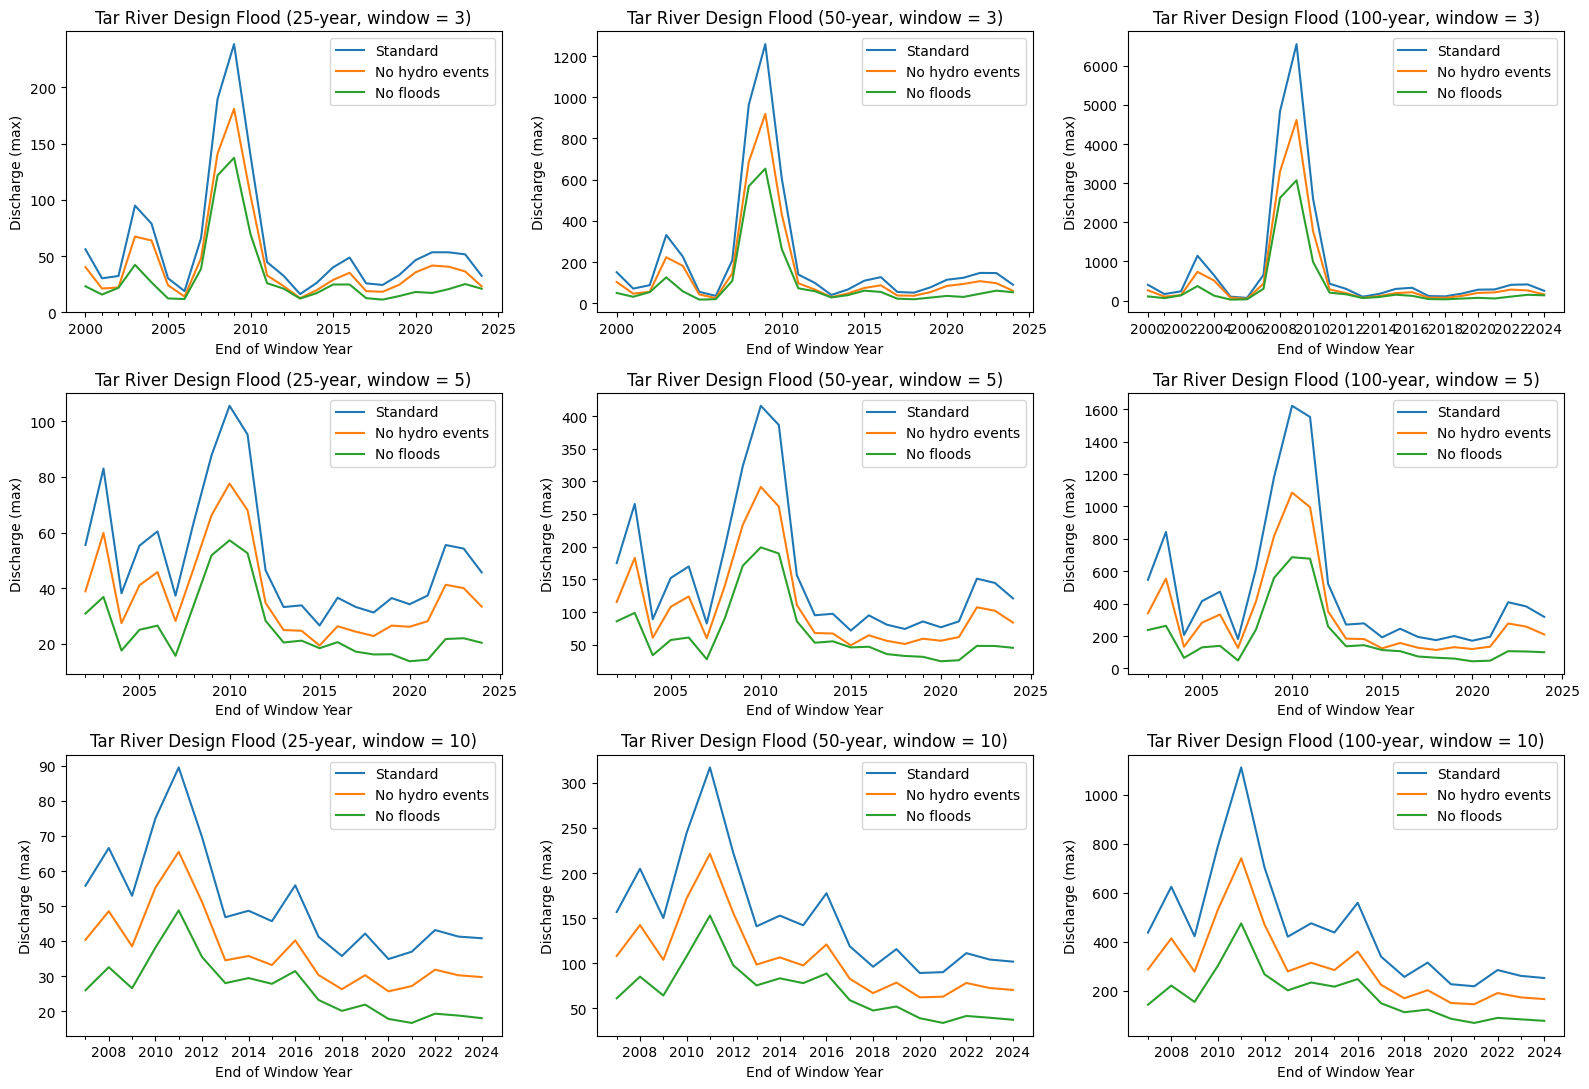

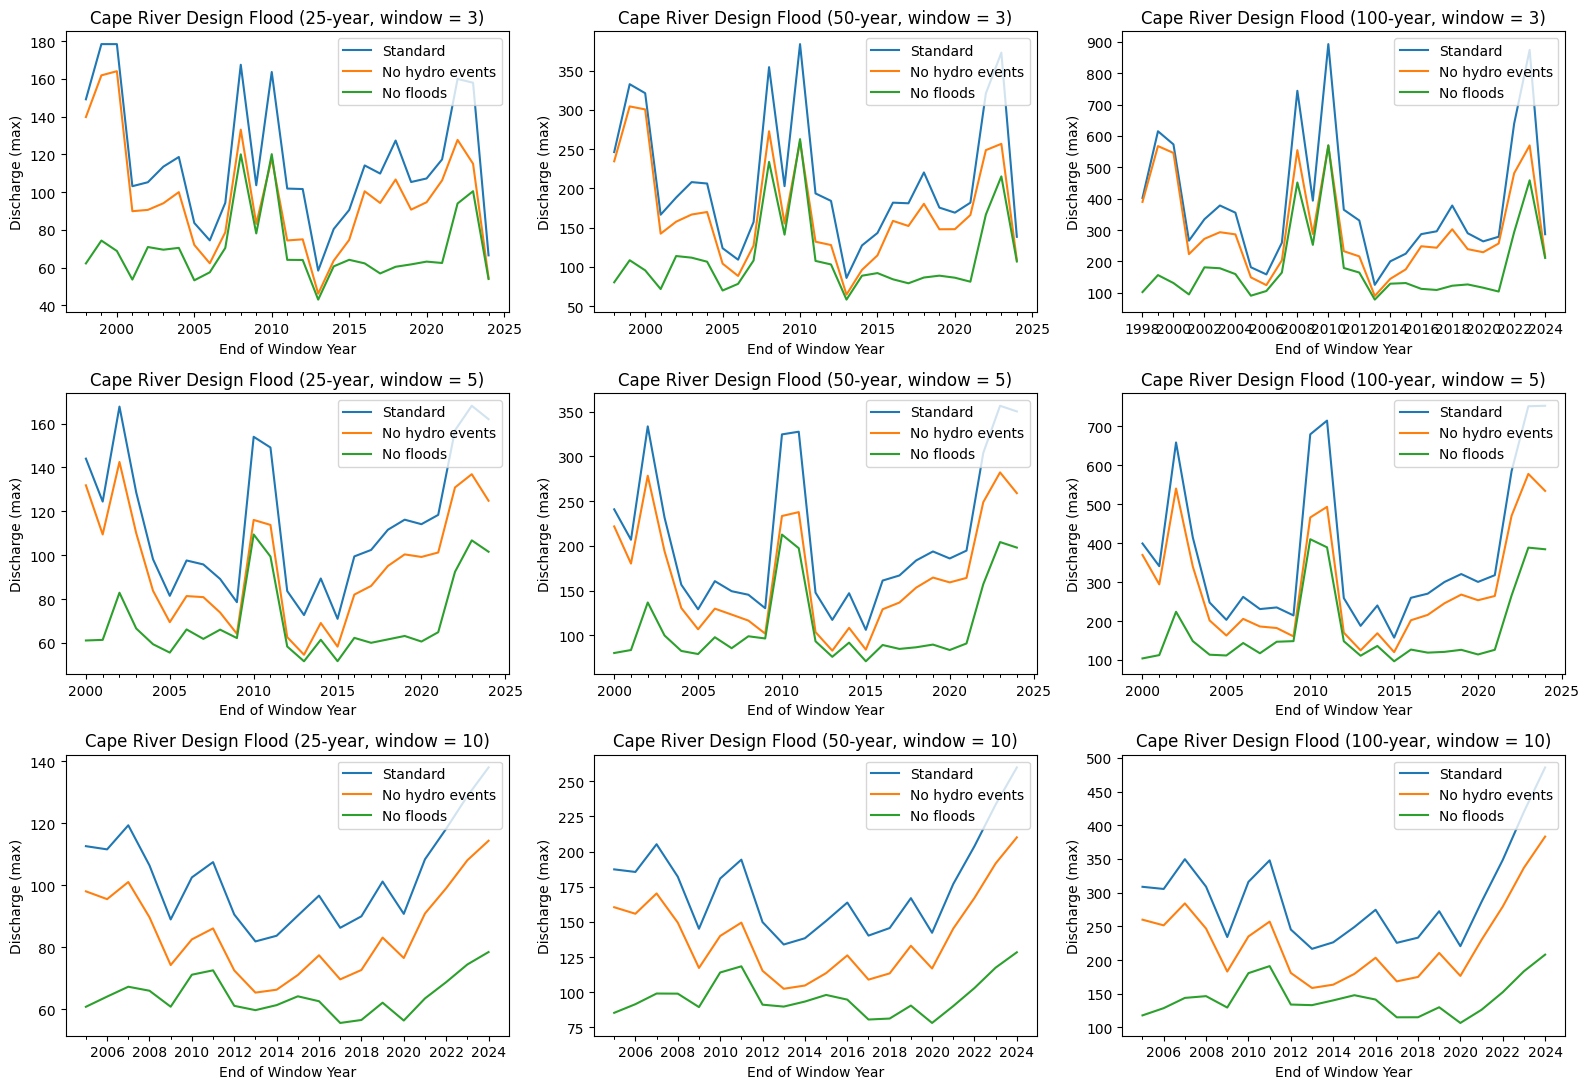

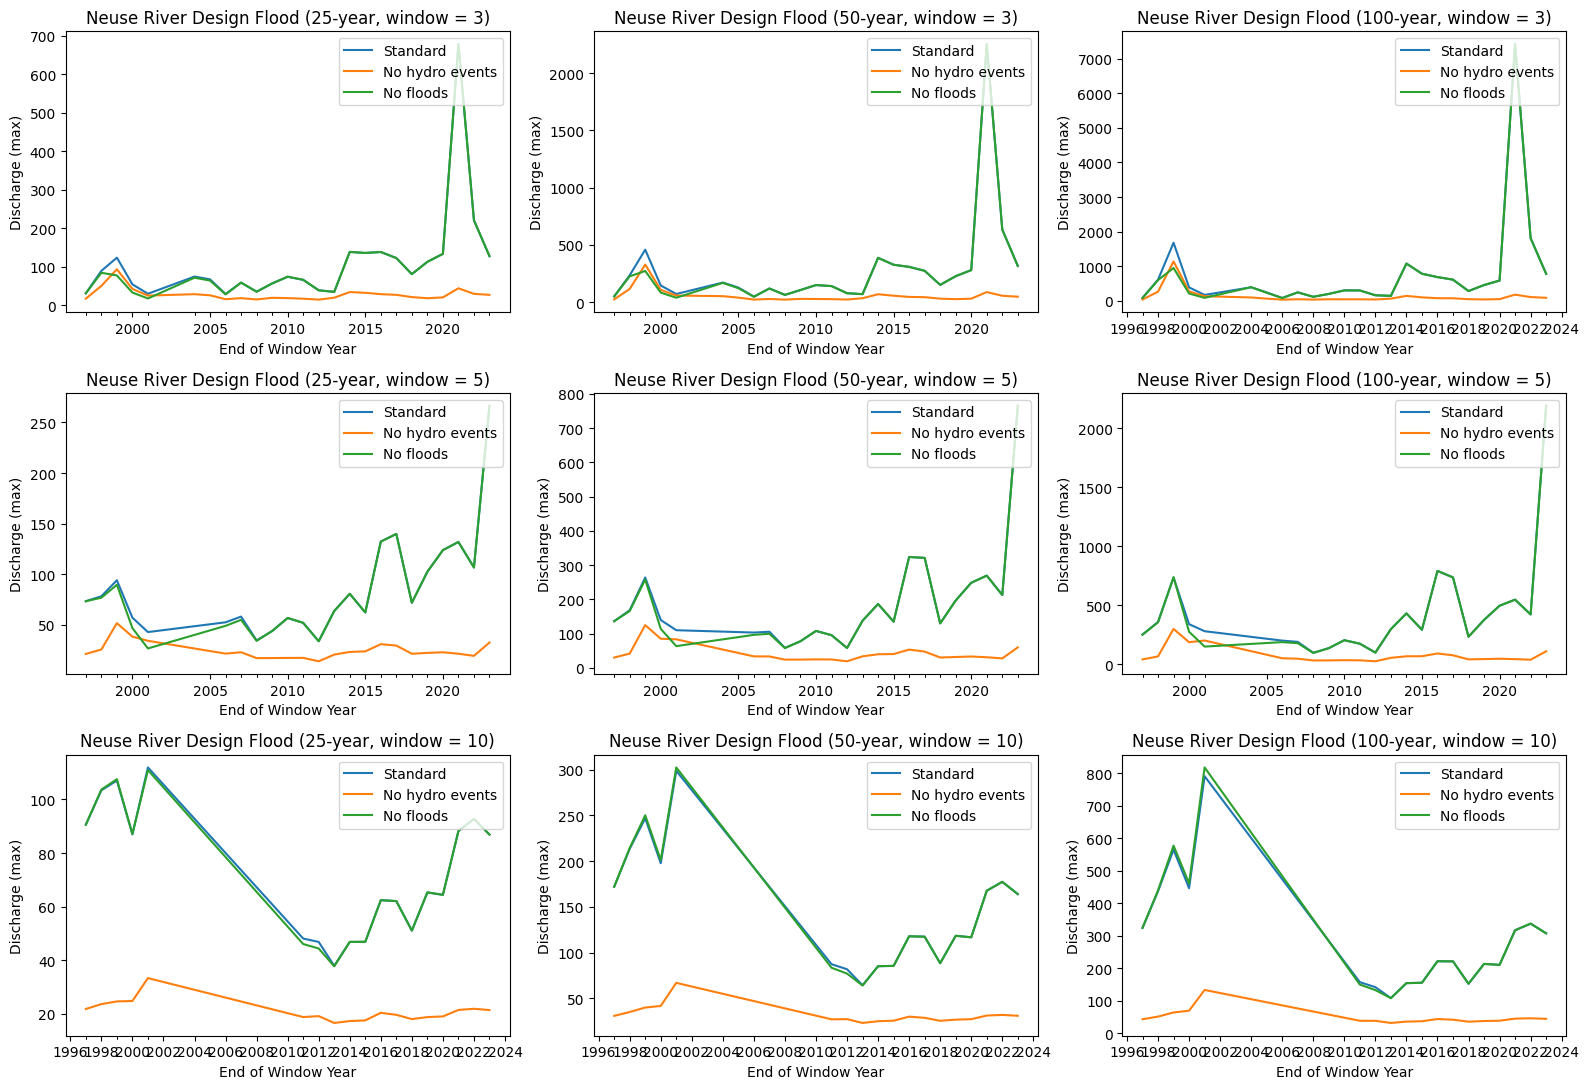

In [34]:
def design_flood_year(year3, year5, year10, hydro3, hydro5, hydro10, flood3, flood5, flood10, rivername):
    fig, axarr = plt.subplots(3, 3, figsize=(16,11), sharey=False)
    #axarr.xaxis.set_major_locator(MaxNLocator(integer=True))   
    # Plot mean discharge per water year
    # plt.sca(axarr[0,0])
    # plt.plot(dataframe[['waterYear','Discharge']].groupby(['waterYear']).mean())
    # plt.title(f'{rivername} Mean Discharge by Water Year')
    # plt.xticks(dataframe['waterYear'].values, minor=True)
    # plt.xlabel('Water Year')
    # plt.ylabel('Discharge (mean)')

    def plotter(year, hydro, flood, period):
        plt.plot(year[year['returnperiod']==period].groupby('endyear')['discharge'].max(),label='Standard')
        plt.plot(hydro[hydro['returnperiod']==period].groupby('endyear')['discharge'].max(),label='No hydro events')
        plt.plot(flood[flood['returnperiod']==period].groupby('endyear')['discharge'].max(),label='No floods')

        #plt.title(f'{rivername} Design Flood ({period}-year, window = 3)')
        plt.xticks(year['endyear'].values, minor=True)
        plt.xlabel('End of Window Year')
        plt.ylabel('Discharge (max)')
        plt.legend(loc="upper right")


    ###### Window

    # 25-year plot
    plt.sca(axarr[0,0])
    plotter(year3,hydro3,flood3,25)
    plt.title(f'{rivername} Design Flood (25-year, window = 3)')

    # 50-year plot
    plt.sca(axarr[0,1])
    plotter(year3,hydro3,flood3,50)
    plt.title(f'{rivername} Design Flood (50-year, window = 3)')


    # 100-year plot
    plt.sca(axarr[0,2])
    plotter(year3,hydro3,flood3,100)
    plt.title(f'{rivername} Design Flood (100-year, window = 3)')
    locator = matplotlib.ticker.MultipleLocator(2)
    plt.gca().xaxis.set_major_locator(locator)
    formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
    plt.gca().xaxis.set_major_formatter(formatter)


    ###### Window = 5

    # 25-year plot
    plt.sca(axarr[1,0])
    plotter(year5,hydro5,flood5,25)
    plt.title(f'{rivername} Design Flood (25-year, window = 5)')

    # 50-year plot
    plt.sca(axarr[1,1])
    plotter(year5,hydro5,flood5,50)
    plt.title(f'{rivername} Design Flood (50-year, window = 5)')


    # 100-year plot
    plt.sca(axarr[1,2])
    plotter(year5,hydro5,flood5,100)
    plt.title(f'{rivername} Design Flood (100-year, window = 5)')


    ###### Window = 10

    # 25-year plot
    plt.sca(axarr[2,0])
    plotter(year10,hydro10,flood10,25)
    plt.title(f'{rivername} Design Flood (25-year, window = 10)')
    locator = matplotlib.ticker.MultipleLocator(2)
    plt.gca().xaxis.set_major_locator(locator)
    formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
    plt.gca().xaxis.set_major_formatter(formatter)

    # 50-year plot
    plt.sca(axarr[2,1])
    plotter(year10,hydro10,flood10,50)
    plt.title(f'{rivername} Design Flood (50-year, window = 10)')
    locator = matplotlib.ticker.MultipleLocator(2)
    plt.gca().xaxis.set_major_locator(locator)
    formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
    plt.gca().xaxis.set_major_formatter(formatter)


    # 100-year plot
    plt.sca(axarr[2,2])
    plotter(year10,hydro10,flood10,100)
    plt.title(f'{rivername} Design Flood (100-year, window = 10)')
    locator = matplotlib.ticker.MultipleLocator(2)
    plt.gca().xaxis.set_major_locator(locator)
    formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
    plt.gca().xaxis.set_major_formatter(formatter)


    
    # Prevent clipping
    plt.tight_layout()
    plt.show()

design_flood_year(tar_3, tar_5, tar_10, tarhydro_3, tarhydro_5, tarhydro_10, tarflood_3, tarflood_5, tarflood_10, 'Tar River')
design_flood_year(cape_3, cape_5, cape_10, capehydro_3, capehydro_5, capehydro_10, capeflood_3, capeflood_5, capeflood_10, 'Cape River')
design_flood_year(neuse_3, neuse_5, neuse_10, neusehydro_3, neusehydro_5, neusehydro_10, neuseflood_3, neuseflood_5, neuseflood_10, 'Neuse River')

In [35]:
def design_flood_year(year3, year5, year10, hydro3, hydro5, hydro10, flood3, flood5, flood10, rivername):
    fig, axarr = plt.subplots(3, 3, figsize=(14,14), sharey=False)
    #axarr.xaxis.set_major_locator(MaxNLocator(integer=True))   
    # Plot mean discharge per water year
    # plt.sca(axarr[0,0])
    # plt.plot(dataframe[['waterYear','Discharge']].groupby(['waterYear']).mean())
    # plt.title(f'{rivername} Mean Discharge by Water Year')
    # plt.xticks(dataframe['waterYear'].values, minor=True)
    # plt.xlabel('Water Year')
    # plt.ylabel('Discharge (mean)')

    Window = 3

    plt.sca(axarr[0,0])

    plt.plot(year3[year3['returnperiod']==25].groupby('endyear')['discharge'].max(),label='25-year')
    plt.plot(year3[year3['returnperiod']==50].groupby('endyear')['discharge'].max(),label='50-year')
    plt.plot(year3[year3['returnperiod']==100].groupby('endyear')['discharge'].max(),label='100-year')

    plt.title(f'{rivername} Design Flood (Window=3)')
    plt.xticks(year3['endyear'].values, minor=True)
    plt.xlabel('End of Window Year')
    plt.ylabel('Discharge (max)')
    plt.legend(loc="upper right")

    # Window = 5

    plt.sca(axarr[0,1])

    plt.plot(year5[year5['returnperiod']==25].groupby('endyear')['discharge'].max(),label='25-year')
    plt.plot(year5[year5['returnperiod']==50].groupby('endyear')['discharge'].max(),label='50-year')
    plt.plot(year5[year5['returnperiod']==100].groupby('endyear')['discharge'].max(),label='100-year')

    plt.title(f'{rivername} Design Flood (Window=5)')
    plt.xticks(year3['endyear'].values, minor=True)
    plt.xlabel('End of Window Year')
    plt.ylabel('Discharge (max)')
    plt.legend(loc="upper right")
    
    # Window = 10

    plt.sca(axarr[0,2])

    plt.plot(year10[year10['returnperiod']==25].groupby('endyear')['discharge'].max(),label='25-year')
    plt.plot(year10[year10['returnperiod']==50].groupby('endyear')['discharge'].max(),label='50-year')
    plt.plot(year10[year10['returnperiod']==100].groupby('endyear')['discharge'].max(),label='100-year')

    plt.title(f'{rivername} Design Flood (Window=10)')
    plt.xticks(year10['endyear'].unique(), minor=True)
    plt.xlabel('End of Window Year')
    plt.ylabel('Discharge (max)')
    plt.legend(loc="upper right")
    
    locator = matplotlib.ticker.MultipleLocator(2)
    plt.gca().xaxis.set_major_locator(locator)
    formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
    plt.gca().xaxis.set_major_formatter(formatter)
    
    #### REMOVED HYDROLOGIC EVENTS

    # Window = 3

    plt.sca(axarr[1,0])

    plt.plot(hydro3[hydro3['returnperiod']==25].groupby('endyear')['discharge'].max(),label='25-year')
    plt.plot(hydro3[hydro3['returnperiod']==50].groupby('endyear')['discharge'].max(),label='50-year')
    plt.plot(hydro3[hydro3['returnperiod']==100].groupby('endyear')['discharge'].max(),label='100-year')

    plt.title(f'{rivername}, No Hydrologic Events (Window=3)')
    plt.xticks(year3['endyear'].values, minor=True)
    plt.xlabel('End of Window Year')
    plt.ylabel('Discharge (max)')
    plt.legend(loc="upper right")

    # Window = 5

    plt.sca(axarr[1,1])

    plt.plot(hydro5[hydro5['returnperiod']==25].groupby('endyear')['discharge'].max(),label='25-year')
    plt.plot(hydro5[hydro5['returnperiod']==50].groupby('endyear')['discharge'].max(),label='50-year')
    plt.plot(hydro5[hydro5['returnperiod']==100].groupby('endyear')['discharge'].max(),label='100-year')

    plt.title(f'{rivername}, No Hydrologic Events (Window=5)')
    plt.xticks(hydro5['endyear'].values, minor=True)
    plt.xlabel('End of Window Year')
    plt.ylabel('Discharge (max)')
    plt.legend(loc="upper right")
    
    # Window = 10

    plt.sca(axarr[1,2])

    plt.plot(hydro10[hydro10['returnperiod']==25].groupby('endyear')['discharge'].max(),label='25-year')
    plt.plot(hydro10[hydro10['returnperiod']==50].groupby('endyear')['discharge'].max(),label='50-year')
    plt.plot(hydro10[hydro10['returnperiod']==100].groupby('endyear')['discharge'].max(),label='100-year')

    plt.title(f'{rivername}, No Hydrologic Events (Window=10)')
    plt.xticks(hydro10['endyear'].unique(), minor=True)
    plt.xlabel('End of Window Year')
    plt.ylabel('Discharge (max)')
    plt.legend(loc="upper right")
    
    locator = matplotlib.ticker.MultipleLocator(2)
    plt.gca().xaxis.set_major_locator(locator)
    formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
    plt.gca().xaxis.set_major_formatter(formatter)




    
    
    # Prevent clipping
    plt.tight_layout()
    plt.show()

design_flood(tar_3, tar_5, tar_10, tarhydro_3, tarhydro_5, tarhydro_10, tarflood_3, tarflood_5, tarflood_10, 'Tar River')

NameError: name 'design_flood' is not defined

In [ ]:
# unused ML stuff
"""
datastuff = pd.get_dummies(neusecombo, columns=['Season'], drop_first=True, dtype=int)
    
#X = datastuff[['Month', 'DayofWeek', 'gageHeight','waterYear', 'Season_Spring', 'Season_Summer','Season_Winter']]
X = datastuff[['waterYear']]
y = datastuff['Discharge']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
wyRange = np.array(range(1991,2003)).reshape(-1,1)
y_rf_pred = rf_model.predict(wyRange)
y_rf_pred
"""

"\ndatastuff = pd.get_dummies(neusecombo, columns=['Season'], drop_first=True, dtype=int)\n    \n#X = datastuff[['Month', 'DayofWeek', 'gageHeight','waterYear', 'Season_Spring', 'Season_Summer','Season_Winter']]\nX = datastuff[['waterYear']]\ny = datastuff['Discharge']\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\nrf_model = RandomForestRegressor(n_estimators=100, random_state=42)\nrf_model.fit(X_train, y_train)\nwyRange = np.array(range(1991,2003)).reshape(-1,1)\ny_rf_pred = rf_model.predict(wyRange)\ny_rf_pred\n"

In [ ]:
# ML function time
'''
def machine_learning_1(dataframe, rivername):
    # Need to do a few things for the model
    # Need to one hot encode 'Season' (since models die if I use non-numbers!)
    # Dropping first for multicollinearity
    dataframe = pd.get_dummies(dataframe, columns=['Season'], drop_first=True, dtype=int)
    
    # Split into train/test sets
    X = dataframe[['Month', 'DayofWeek', 'gageHeight','waterYear', 'Season_Spring', 'Season_Summer','Season_Winter']]
    y = dataframe['Discharge']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Naive baseline
    y_train_median = y_train.median()
    y_naive_pred = np.full(shape=y_test.shape, fill_value=y_train_median)

    # Naive MAE, MSE, RMSE
    mae_naive = mean_absolute_error(y_test, y_naive_pred)
    mse_naive = mean_squared_error(y_test, y_naive_pred)
    rmse_naive = np.sqrt(mse_naive)

    # OLR
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    y_pred = linear_model.predict(X_test)

    # OLR MAE, MSE, RMSE
    mae_linear = mean_absolute_error(y_test, y_pred)
    mse_linear = mean_squared_error(y_test, y_pred)
    rmse_linear = np.sqrt(mse_linear)
    
    # Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_rf_pred = rf_model.predict(X_test)

    # RF MAE, MSE, RMSE
    mae_rf = mean_absolute_error(y_test, y_rf_pred)
    mse_rf = mean_squared_error(y_test, y_rf_pred)
    rmse_rf = np.sqrt(mse_rf)

    # SVR, rbf kernel
    svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr_model.fit(X_train, y_train)
    y_svr_pred = svr_model.predict(X_test)

    # SVR MAE, MSE, RMSE
    mae_svr = mean_absolute_error(y_test, y_svr_pred)
    mse_svr = mean_squared_error(y_test, y_svr_pred)
    rmse_svr = np.sqrt(mse_svr)

    # Gradient boosting
    gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gbr_model.fit(X_train, y_train)
    y_gbr_pred = gbr_model.predict(X_test)

    # Gradient boosting MAE, MSE, RMSE
    mae_gbr = mean_absolute_error(y_test, y_gbr_pred)
    mse_gbr = mean_squared_error(y_test, y_gbr_pred)
    rmse_gbr = np.sqrt(mse_gbr)
    
    # KNN 

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # n=5
    knn_model = KNeighborsRegressor(n_neighbors=5)
    knn_model.fit(X_train_scaled, y_train)
    y_knn_pred = knn_model.predict(X_test_scaled)

    # KNN MAE, MSE, RMSE
    mae_knn = mean_absolute_error(y_test, y_knn_pred)
    mse_knn = mean_squared_error(y_test, y_knn_pred)
    rmse_knn = np.sqrt(mse_knn)

    # Simple neural network model
    # I don't feel the need to mess around with this too much,
    # since optimizing a NN isn't my main focus with this function.
    # I'd just like to see how it performs with the given data
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
    y_nn_pred = model.predict(X_test_scaled).flatten()

    # NN MAE, MSE, RMSE
    mae_nn = mean_absolute_error(y_test, y_nn_pred)
    mse_nn = mean_squared_error(y_test, y_nn_pred)
    rmse_nn = np.sqrt(mse_nn)

    results = {
    'Model': ['Naive Baseline', 'Linear Regression', 'Random Forest', 'SVR', 'Gradient Boosting', 'KNN', 'Neural Network'],
    'MAE': [mae_naive, mae_linear, mae_rf, mae_svr, mae_gbr, mae_knn, mae_nn],
    'MSE': [mse_naive, mse_linear, mse_rf, mse_svr, mse_gbr, mse_knn, mse_nn],
    'RMSE': [rmse_naive, rmse_linear, rmse_rf, rmse_svr, rmse_gbr, rmse_knn, rmse_nn]
    }
    results_df = pd.DataFrame(results)
    results_df.set_index('Model', inplace=True)

    # Sorted results by RMSE
    results_df_sorted_by_rmse = results_df.sort_values(by='RMSE', ascending=True)
    print(f'{rivername} Model Performance')
    print(results_df_sorted_by_rmse)


machine_learning_1(tarDf, 'Tar River')
machine_learning_1(neuseDf, 'Neuse River')
machine_learning_1(capeDf, 'Cape Fear River')
'''

"\ndef machine_learning_1(dataframe, rivername):\n    # Need to do a few things for the model\n    # Need to one hot encode 'Season' (since models die if I use non-numbers!)\n    # Dropping first for multicollinearity\n    dataframe = pd.get_dummies(dataframe, columns=['Season'], drop_first=True, dtype=int)\n    \n    # Split into train/test sets\n    X = dataframe[['Month', 'DayofWeek', 'gageHeight','waterYear', 'Season_Spring', 'Season_Summer','Season_Winter']]\n    y = dataframe['Discharge']\n    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n    # Naive baseline\n    y_train_median = y_train.median()\n    y_naive_pred = np.full(shape=y_test.shape, fill_value=y_train_median)\n\n    # Naive MAE, MSE, RMSE\n    mae_naive = mean_absolute_error(y_test, y_naive_pred)\n    mse_naive = mean_squared_error(y_test, y_naive_pred)\n    rmse_naive = np.sqrt(mse_naive)\n\n    # OLR\n    linear_model = LinearRegression()\n    linear_model.fit(X_train, 